# Sentiment Analysis of Valkyr's Rework (Warframe)

In [156]:
import pickle
import pandas as pd
import numpy as np

In [157]:
with open('data/forum_posts.pkl', 'rb') as f:
    df = pickle.load(f)
df.head()

,author,likes,date,comment
0,[DE]Sam,108,May 9,"VALKYR\nTenno, A berserker’s fury fills the ai..."
1,oswarlan,371,May 10,"Honestly, losing the invulnerability on Hyster..."
2,StageNameFrank,52,May 10,"finally, valkyr's slide attack isn't the only ..."
3,18K-,12,May 10,Love it!
4,dice,21,May 10,Valkyr's Warcry is now recastable. Hooray!


## Preprocessing

The only columns that can have missing values are `author`, `date` and `comment`.

In [158]:
print(np.sum(df.loc[:, 'author'] == ''), np.sum(df.loc[:, 'date'] == ''), np.sum(df.loc[:, 'comment'] == ''))

0 0 5


In [159]:
df.loc[df.loc[:,'comment'] == '', :]

,author,likes,date,comment
93,0phiuchus,5,May 10,
1668,Heavy_Calibre,9,May 12,
2104,UnusualFiveOFour,21,May 13,
4652,Dallama9,4,May 19,
5027,DDiablO.,8,Tuesday at 05:04 PM,


Only two comments are missing, and they do not have many likes, so I will remove them:

In [160]:
df = df.loc[df.loc[:,'comment'] != '', :]
df.shape

(5321, 4)

Finally, let's reset the indexes:

In [161]:
# Reset index count, but don't store the old ones as a new column
df.reset_index(drop=True, inplace=True) 
df.tail()

,author,likes,date,comment
5316,Astra_Ahina,0,Wednesday at 06:54 AM,I did add a rework idea of my own here: Not ...
5317,Gaxxian,6,Wednesday at 07:10 AM,This silence is slowly fueling the idea they j...
5318,AegidiusF,3,Wednesday at 07:14 AM,and didn't remove Para's finishers This is som...
5319,festivneer,15,Wednesday at 07:16 AM,"thinking about it, the part that actually make..."
5320,Yulfan,0,Wednesday at 07:52 AM,"thinking about it, the part that actually make..."


### Likes as int

In [162]:
df['likes'] = df['likes'].astype('int')

# Check if NAs where created
np.sum(np.isnan(df['likes']))

np.int64(0)

### Date as datetime

In [163]:
a = 1
b = 2
c = a - b if a>b else 0
print(c)

0


In [164]:
df['date'].unique()[:15]

array(['May 9', 'May 10', 'May 11', 'May 12', 'May 13', 'May 14',
       'May 15', 'May 16', 'May 17', 'May 18', 'May 19', 'May 20',
       'Tuesday at 12:13 PM', 'Tuesday at 12:19 PM',
       'Tuesday at 12:20 PM'], dtype=object)

In [165]:
# Initialize column
df.loc[:, 'clean_date'] = 0

for idx, row in df.iterrows():
    # Split date by ' '
    complete_date = row['date'].split(' ')

    if len(complete_date) == 2: # e.g. May 10 (first dates)
        # Add year at the back
        complete_date.append('2025')
    
    else: # e.g. Wednesday at 05:41 AM (last dates)
        weekday = {
            'Monday': 1, 'Tuesday': 2, 'Wednesday':3, 'Thursday': 4,
            'Friday': 5, 'Saturday': 6, 'Sunday': 7 
        }

        # Get previous date
        prev_date = df.loc[idx-1, 'date']
        prev_date = prev_date.split(' ')

        # Assign number (day)
        if len(prev_date) == 2: # e.g. May 10
            # Get day from previous date (assumes the same day it changed format)
            day = int(prev_date[1])

            # Store correct information in complete_date: [month: str, day: int, year: int]
            complete_date = [str(prev_date[0]), str(day), str(2025)]

        else: # e.g. Wednesday at 05:41 AM (last dates)
            # Get day difference from previous date
            a = weekday[complete_date[0]]
            b = weekday[prev_date[0]] 
            day_diff = a - b if a>=b else 1 # if changed to following week, add one (do not substract)

            # Get current day
            previous_day = df.loc[idx-1, 'clean_date'].split('-')[1]
            day = int(previous_day) + day_diff
            
            # Store correct information in complete_date: [month: str, day: int, year: int]
            previous_month = df.loc[idx-1, 'clean_date'].split('-')[0]
            complete_date = [str(previous_month), str(day), str(2025)]
    
    # Use '-' separation instead
    complete_date = '-'.join(complete_date) # Final Format: May-10-2025

    # Add to new column
    df.loc[idx, 'clean_date'] = complete_date

# Change dtype to datetime
df['clean_date'] = pd.to_datetime(df['clean_date']).dt.strftime('%d/%m/%Y')
df[4909:4914]

C:\Users\domin\AppData\Local\Temp\ipykernel_12028\2569957792.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'May-9-2025' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[idx, 'clean_date'] = complete_date


,author,likes,date,comment,clean_date
4909,-skimmer-,1,May 20,You somehow think you're a better Valkyr main ...,20/05/2025
4910,xiaos03,5,May 20,Is that a fact? Let's review. 1. Invincibility...,20/05/2025
4911,Yulfan,1,Tuesday at 12:13 PM,"very fair, I use V.snare for my crescendo claw...",20/05/2025
4912,Tueneap,5,Tuesday at 12:19 PM,"No, its really not.\nAs pointed out before, in...",20/05/2025
4913,TempestSonata,9,Tuesday at 12:20 PM,Is that a fact? Let's review. 1. Invincibility...,20/05/2025


### Text Cleaning
Although it is advantageous to use text as it is for sentiment analysis, later steps require cleaned text data.

In [166]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')

def clean_text(text: str):
    # Lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(pattern='[^a-zA-Z\d\s\']', repl='', string=text)

    # Tokenization
    words = word_tokenize(text, language='english')

    # Remove Stop-Words
    stopwords_set = set(stopwords.words('english'))
    clean_words =  [w for w in words if w not in stopwords_set and len(w) > 4]

    # Lemmatization: running, ran, runner... -> run
    wnl = WordNetLemmatizer() # initialize
    return [
        wnl.lemmatize(w, pos='v') for w in clean_words
    ]

df['clean_comment'] = df['comment'].apply(clean_text)
df.head()

<>:14: DeprecationWarning: invalid escape sequence '\d'
<>:14: DeprecationWarning: invalid escape sequence '\d'
C:\Users\domin\AppData\Local\Temp\ipykernel_12028\1074478858.py:14: DeprecationWarning: invalid escape sequence '\d'
  text = re.sub(pattern='[^a-zA-Z\d\s\']', repl='', string=text)


,author,likes,date,comment,clean_date,clean_comment
0,[DE]Sam,108,May 9,"VALKYR\nTenno, A berserker’s fury fills the ai...",09/05/2025,"[valkyr, tenno, berserkers, fill, corpus, grin..."
1,oswarlan,371,May 10,"Honestly, losing the invulnerability on Hyster...",10/05/2025,"[honestly, lose, invulnerability, hysteria, ki..."
2,StageNameFrank,52,May 10,"finally, valkyr's slide attack isn't the only ...",10/05/2025,"[finally, valkyr, slide, attack, viable]"
3,18K-,12,May 10,Love it!,10/05/2025,[]
4,dice,21,May 10,Valkyr's Warcry is now recastable. Hooray!,10/05/2025,"[valkyr, warcry, recastable, hooray]"


## Sentiment Classification

To begin with, let's classify in basic polarities — positive, neutral and negative —, which can be done with the `nltk` library and its `VADER` lexicon.

In [167]:
# Download required lexicon 
import nltk
# nltk.download('vader_lexicon') # <--- uncomment this line to download

In [168]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Analyze each comment
results = {
    'index': [], 'negative_score': [], 'neutral_score': [], 
    'positive_score': [], 'compound': [], 'label': []
}

for index, post in df.iterrows():
    comment = post['comment']
    scores = sid.polarity_scores(comment)

    # Store scores
    results['index'].append(index)
    results['negative_score'].append(scores['neg'])
    results['neutral_score'].append(scores['neu'])
    results['positive_score'].append(scores['pos'])
    results['compound'].append(scores['compound'])
    results['label'].append(
        'positive' if scores['compound'] > 0.5
        else 'negative' if scores['compound'] < -0.5
        else 'neutral'
    )

In [169]:
data = pd.DataFrame.from_dict(results)
data.head(10)

,index,negative_score,neutral_score,positive_score,compound,label
0,0,0.293,0.604,0.103,-0.9988,negative
1,1,0.260,0.491,0.249,-0.1027,neutral
2,2,0.220,0.780,0.000,-0.4767,neutral
3,3,0.000,0.182,0.818,0.6696,positive
4,4,0.000,0.582,0.418,0.5562,positive
5,5,0.000,0.753,0.247,0.3182,neutral
6,6,0.127,0.873,0.000,-0.4404,neutral
7,7,0.000,0.417,0.583,0.6808,positive
8,8,0.000,0.741,0.259,0.4939,neutral
9,9,0.278,0.722,0.000,-0.4019,neutral


## Data Exploration

In [170]:
data_no_introduction = data.copy()
data_no_introduction = data_no_introduction.drop(0, axis=0)

In [171]:
def compute_wordcloud(opinion_label: str, data: pd.DataFrame = data_no_introduction):
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt

    # Extract comments with the same opinion
    indexes = data.loc[data['label'] == opinion_label, 'index']
    comments = df.loc[indexes, 'clean_comment']

    # List of all words in comments
    all_words = []
    for comment in comments:
        all_words.extend(comment)
    
    # Initialize WordCloud
    cloud = WordCloud(
        width=1000, height=500, background_color='black', contour_width=10,
        max_words=100, stopwords=('still', 'would')
    ).\
        generate(' '.join(all_words))
    
    # Plot WordCloud
    plt.figure(figsize=(10,5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud: {opinion_label} opinion comments')
    plt.show()

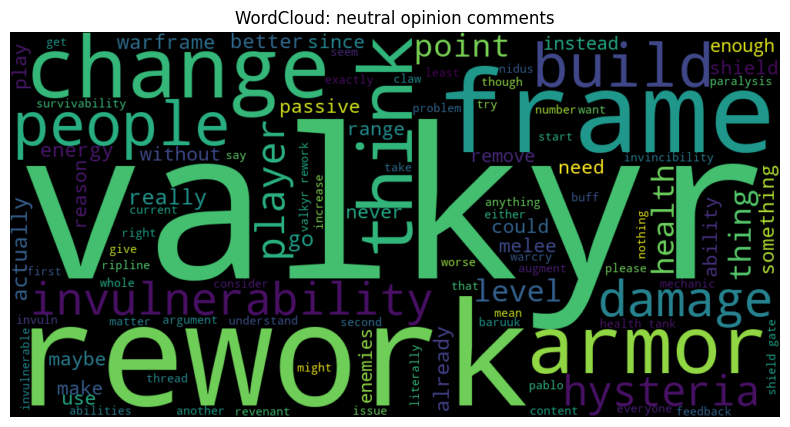

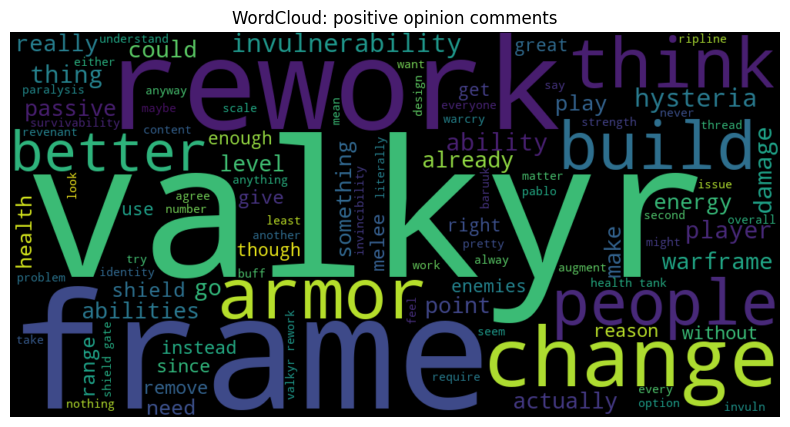

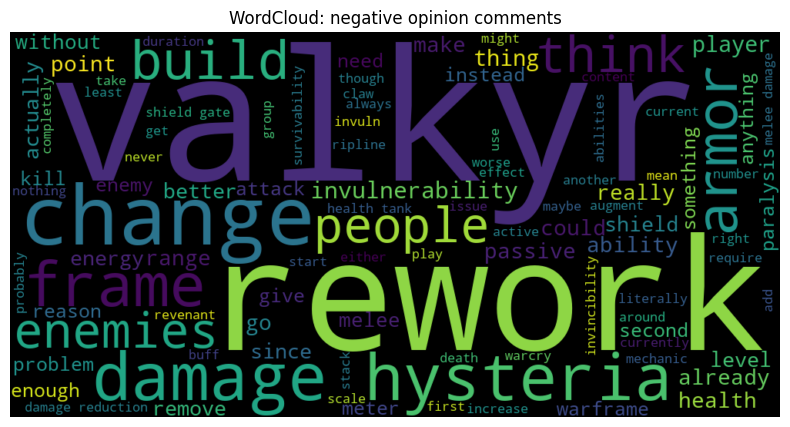

In [172]:
for opinion_label in data_no_introduction['label'].unique():
    compute_wordcloud(opinion_label)

### Polarity Weight
Which kind of opinion — positive, neutral or negative — is the most prominent:

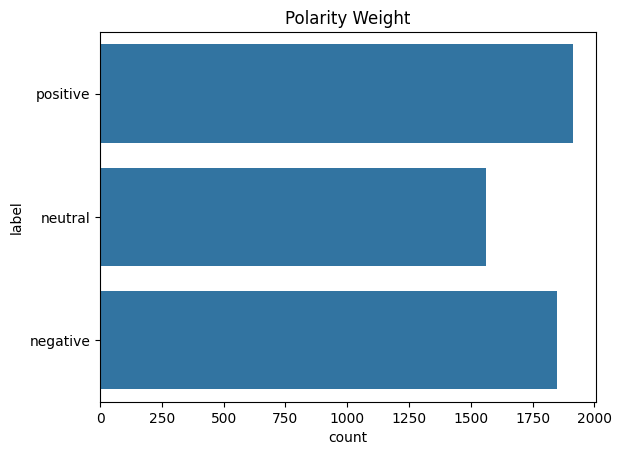

In [173]:
import seaborn as sb
import matplotlib.pyplot as plt

sb.countplot(data['label'], order=('positive', 'neutral', 'negative'))
plt.title('Polarity Weight')
plt.show()

### Opinion evolution

In [181]:
# Join date to opinion dataframe by pandas index (on=None)
data_joined = data.join(other=df.loc[:,('clean_date')], on=None)

# Count occurrences of each pair (date, label)
opinion_by_date = data_joined.groupby(['clean_date', 'label']).count().iloc[:,:1]
opinion_by_date.columns = ['count']

# MultiIndex: add all possibilities (default to 0)
all_dates = df['clean_date'].unique()
all_labels = data['label'].unique()
full_index = pd.MultiIndex.from_product([all_dates, all_labels], names=('date', 'label'))

# Reindex to include all possibilities
opinion_by_date = opinion_by_date.reindex(full_index, fill_value=0)
opinion_by_date[:6]

count
date       label          
09/05/2025 negative      1
           neutral       0
           positive      0
10/05/2025 negative    138
           neutral     153
           positive    157

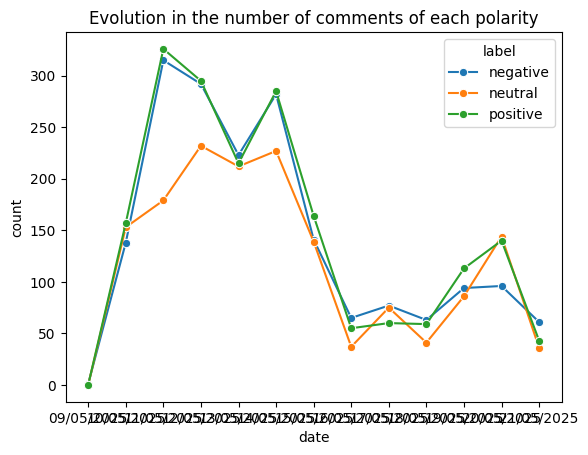

In [175]:
sb.lineplot(opinion_by_date, x='date', y='count', hue='label', marker='o')
plt.title('Evolution in the number of comments of each polarity')
plt.show()

### Top Users by sentiment
Let's analyze who are the most active and polarized users, and the most influential comments for each sentiment.

In [176]:
def compute_topNusers(opinion_label: str, df: pd.DataFrame = df, opinions: pd.DataFrame = data, N: int = 3):
    print('-' * 50)
    print(f'{opinion_label.capitalize()}')
    print('-' * 50)

    # Extract comments with the same opinion
    opinions = opinions.iloc[1:, :] # skip introduction post
    indexes = opinions.loc[opinions['label'] == opinion_label, 'index']
    opinions = opinions.loc[indexes, :]

    df = df.iloc[1:, :] # skip introduction post
    comments = df.loc[indexes, :]

    # Top N most active users
    active = comments.groupby('author')['comment'].count().sort_values(ascending=False)[:N]
    
    
    print(f'Top {N} most active users:')
    for user in active.index.values:
        print(f'· {user} ({active.loc[user]} comments)')
    print('') # skip line

    # Top N most polarized users
    compound_opinions = opinions.loc[:, ('compound',)].copy() # focus on compound opinion
    compound_opinions['author'] = comments.loc[:, ('author')] # add author
    compound_opinions = compound_opinions.groupby('author')['compound'].\
        mean().abs().\
        sort_values(ascending=False)[:N]
    
    print(f'Top {N} polarized users:')
    for (author, compound) in compound_opinions.items():
        print(f'· {author} ({np.round(compound, 4) * 100} % {opinion_label})')
    print('') # skip line

    # Top N most influential comments
    influential = comments.sort_values(by='likes', ascending=False)['comment'].iloc[:N]

    print(f'Top {N} influential comments:')
    for index, comment in influential.items():
        print(f'· {comment}')

    print('\n')

compute_topNusers('positive')
compute_topNusers('neutral')
compute_topNusers('negative')

--------------------------------------------------
Positive
--------------------------------------------------
Top 3 most active users:
· VoidIII (108 comments)
· Tueneap (69 comments)
· festivneer (60 comments)

Top 3 polarized users:
· Dracosavarian (99.79 % positive)
· ThePrimordialChaos (99.79 % positive)
· (XBOX)Moopigs478669 (99.45 % positive)

Top 3 influential comments:
· She does way more damage She did 14millions per hit reliably, sometimes more. She doesnt need dmg, but better abilities in general. Now, we end with more or less the same abilities, somewhat improved, but at the same time now you will need to invest into shield tanking, so you will get less mods for your abilities. Overall, nerfed.
· Adding damage to a frame that hit damage cap with ease and removing her invulnerability basically killed her but thank for the free Warframe slots now
· Hysteria no longer turns Valkyr invulnerable.  Great, Valk will be dead on arrival with this specific change. 

Please look at E

### Sentiment vs Engagement
Mean number of likes per opinion.

In [177]:
engagement = df.loc[:, ('likes',)].join(
    other=data.loc[:, ('label',)], on=None # = on pandas index
)

engagement.groupby('label').mean()

,likes
label,
negative,4.995671
neutral,5.969250
positive,4.133368


Neutral and negative posts have better engagement.

### Frequent Phrases
Identify common 2-word and 3-word phrases in a sentiment category (N-grams).

In [178]:
def find_NGrams(opinion_label: str, N_min: int = 2, N_max: int = 3, topN: int = 10):
    from sklearn.feature_extraction.text import CountVectorizer
    # Initialize N-Gram counter
    vectorizer = CountVectorizer(
        ngram_range=(N_min, N_max), stop_words='english'
    )

    # Initialize data
    comments = df.loc[data['label'] == opinion_label, 'clean_comment']
    joined_comments = comments.transform(lambda x: ' '.join(x))
    
    # Find N-Grams
    X = vectorizer.fit_transform(joined_comments)

    # Count repetition
    count_ngrams = X.sum(axis=0)
    phrases = [
        (ngram, count_ngrams[0, idx])
        for (ngram, idx) in vectorizer.vocabulary_.items()
    ]

    # Sort descending
    phrases = sorted(phrases, key=lambda x: x[1], reverse=True)

    # Show results
    print(f'Most Common N-Grams in {opinion_label.capitalize()} Comments:')
    for idx in range(topN):
        phrase = phrases[idx][0]
        count = phrases[idx][1]
        print(f'{phrase}: {count}')
    print('') # skip line

for label in data['label'].unique():
    find_NGrams(opinion_label=label)

Most Common N-Grams in Negative Comments:
damage reduction: 244
health tank: 214
shield gate: 172
melee damage: 148
slide attack: 119
valkyr rework: 98
energy drain: 93
enemy damage: 84
health armor: 83
damage damage: 71

Most Common N-Grams in Neutral Comments:
health tank: 100
shield gate: 77
valkyr rework: 71
damage reduction: 45
rework valkyr: 37
level content: 31
prolong paralysis: 28
health armor: 27
play valkyr: 27
grind finishers: 26

Most Common N-Grams in Positive Comments:
health tank: 181
valkyr rework: 126
shield gate: 120
health armor: 84
damage reduction: 78
rework valkyr: 76
play valkyr: 72
remove invulnerability: 69
melee frame: 62
level content: 61



### LDA: Topic Modeling per Sentiment

In [179]:
def print_topics(model, vectorizer, top_n=10):
    words = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(model.components_):
        print(f"\nTopic #{idx + 1}:")
        print(", ".join([words[i] for i in topic.argsort()[-top_n:]]))

def lda_topic_extraction(label_opinion: str, n_topics: int = 3, seed: int = 33):
    from sklearn.decomposition import LatentDirichletAllocation
    from sklearn.feature_extraction.text import CountVectorizer

    # Build Subset
    subset = df.loc[data['label'] == label_opinion, 'comment']

    # Vectorize comments and count words
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    X = vectorizer.fit_transform(subset)

    # Perform LDA: extract topics
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=seed)
    lda.fit(X)

    # Print topics
    print_topics(lda, vectorizer)

for topic_label in data['label'].unique():
    print('-' * 50)
    print(f'Top 3 Topics from {topic_label.capitalize()} Comments')
    print('-' * 50)
    lda_topic_extraction(topic_label)
    print('')

--------------------------------------------------
Top 3 Topics from Negative Comments
--------------------------------------------------

Topic #1:
enemies, make, rework, like, hysteria, health, just, valkyr, armor, damage

Topic #2:
frame, people, don, melee, rework, range, like, damage, just, valkyr

Topic #3:
seconds, melee, valkyr, game, just, enemies, death, 75, damage, rage

--------------------------------------------------
Top 3 Topics from Neutral Comments
--------------------------------------------------

Topic #1:
rage, energy, armor, frame, damage, hysteria, rework, valkyr, just, like

Topic #2:
play, thread, really, said, invulnerability, don, people, just, valkyr, rework

Topic #3:
use, damage, rework, game, health, don, like, just, valkyr, armor

--------------------------------------------------
Top 3 Topics from Positive Comments
--------------------------------------------------

Topic #1:
ability, better, health, hysteria, rework, armor, energy, just, like, valkyr


### LDA: Focused Model on 'Health'

In [180]:
import pyLDAvis
import pyLDAvis.lda_model
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Focus on health related comments
health_df = df[df['comment'].str.contains('health', case=False, na=False)]
health_df = health_df['comment']

# Vectorize comments and count words
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(health_df)

# Perform LDA: extract topics
lda = LatentDirichletAllocation(n_components=3, random_state=33)
lda.fit(X)

# Visualize with pyLDAvis
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda, X, vectorizer)
pyLDAvis.display(panel)